# より良い問題設計へ向けて： 何が強化学習を難しくするのかを理解しよう
> 強化学習苦手の会 Advent Calendar 2020 20日目

- toc: true 
- badges: true
- comments: true
- categories: [RL, ja]

# はじめに

> Note: このブログは[強化学習苦手の会 Advent Calendar 2020](https://adventar.org/calendars/5128)20日目の記事として書かれました



強化学習は、「確率的に状態遷移する系の上で逐次的に意思決定する」問題を定義するフレームワークです。
深層学習のコモディティ化により従来は大変だった[^1] ニューラルネットワークの訓練が簡単になったことや、
Alpha GOなど深層強化学習(Deep RL)の成功により、[対話システム][Li16]・[経済][Zheng20]
など、様々なアプリケーションで強化学習の利用が試みられているように思います。
僕個人としても、将来的には、強化学習の特性を活かせるような応用分野がたくさん見つかって、広く活用されるといいな、と思います。

その一方で、他分野の研究をされている方がただツールとして強化学習を使う、
というシーンを想定すると、ややとっつきづらい面があるように思います。
その原因として、苦手の会などで僕が聞きかじった範囲では、
- 問題(or MDP)を定義するのがそもそも大変
- 色々な手法があって、何がなんだかよくわからない

などが、候補として考えられるようです。

このブログ記事では、この2つの疑問に対して、**何が強化学習の問題を難しくするのか** という観点から解説を試みたいと思います。
難しさの要因がわかれば、
- 簡単になるように問題を設計できるし、
- 簡単な問題を簡単に解くような手法を選んでこれる

のではないか、というシナリオです。

特に、
- MDPを解くことの難しさ
- データを収集することの難しさ
- 収集したデータから学習することの難しさ

という、3つの観点からアプローチしていきます。
初心者の方でも読めるように、強化学習についての前提知識についてはなるべく記事の中で補足します。
そのぶん記述に厳密さを書くところが多々あると思いますが、ご容赦ください。

[Li16]: https://arxiv.org/abs/1606.01541
[Zheng20]: https://arxiv.org/abs/2004.13332

[^1]: Suttonも[誤差逆伝播を使うのにはトリッキーな工夫が必要だ](http://incompleteideas.net/RL-FAQ.html#backpropagation)と言っています。

# 最適化問題としての側面: MDPを解くことの難しさ

強化学習は、エージェントが集めてきたデータを使って、マルコフ決定過程上で「いい感じ」に行動する方策を
訓練する問題のことです。
しかしこの章では、学習のことはいったん忘れてください。
学習しないでいいのは、マルコフ決定過程の情報を全部知っているからです。
このとき、どのくらい問題を解くのが大変かを考えていきましょう。

ではまず、マルコフ決定過程 (Markov Decision Process, 以後MDPと呼ぶ)を導入します。

| 定義1 |
|:----------------------:|
| MDPは、状態集合 $\mathcal{S}$、行動集合 $\mathcal{A}$、状態遷移確率 $P: \mathcal{S} \times \mathcal{A} \rightarrow \mathcal{S}$, 報酬関数 $\mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$, 割引報酬率 $\gamma$ から成る|

なんだか、記号で言われてもよくわからないですね。
お絵描きしてみましょう。

In [351]:
# collapse-hide
from typing import Dict, Optional, Sequence, Tuple

import numpy as np
from matplotlib import cm, patches, pyplot
from matplotlib.axes import Axes
from matplotlib.collections import PatchCollection
from matplotlib.text import Annotation

Point = Tuple[float, float]


def a_to_b(
    ax: Axes,
    a: Point,
    b: Point,
    text: str = "",
    style: str = "normal",
    **kwargs,
) -> Annotation:
    STYLE_ALIASES: Dict[str, str] = {
        "normal": "arc3,rad=-0.4",
        "self": "arc3,rad=-1.6",
    }
    return ax.annotate(
        text,
        xy=b,
        xytext=a,
        arrowprops=dict(
            shrinkA=10,
            shrinkB=10,
            patchA=None,
            patchB=None,
            width=1.0,
            headwidth=6.0,
            connectionstyle=STYLE_ALIASES.get(style, style),
            **kwargs,
        ),
    )


class ChainMDP:
    def __init__(
        self,
        transition_prob: Sequence[Sequence[Sequence[float]]],
        reward_function: Sequence[Sequence[float]],
    ) -> None:
        self.p = np.array(transition_prob)  # |S| x |A| x |S|
        self.r = np.array(reward_function)  # |S| x |A|
        self.n_states, self.n_actions = self.r.shape
        assert (
            self.p.shape[0] == self.p.shape[2] == self.n_states
        ), "State shape mismatches"
        assert self.p.shape[1] == self.n_actions, "Action shape mismatches"
        assert self.n_actions <= 4, f"Too many actions: {self.n_actions}"
        # For plotting
        self.circles = []
        self.arrows = []

    def show(self, ax: Optional[Axes] = None) -> Axes:
        if len(self.circles) > 0:
            return ax
        # Some constants
        offset, shift = 0.5, 0.4
        if ax is None:
            fig = pyplot.figure(1, (self.n_states * 2 + 1, self.n_actions * 2 + 1))
            ax = fig.add_axes([0, 0, 1, 1], aspect=1.0)
        ax.set_xlim(0, self.n_states * 2 + 1)
        ax.set_ylim(0, self.n_actions * 2 + 1)
        ax.set_xticks([])
        ax.set_yticks([])
        self.rectangles = [
            patches.Rectangle(
                (2 * i + offset * 2 - 0.1, offset - 0.1),
                1.2,
                (self.n_actions + offset) * 2 - (offset - 0.1) * 2,
            )
            for i in range(self.n_states)
        ]
        for i in range(self.n_states):
            ax.text(
                2 * i + offset * 2,
                self.n_actions * 2 + 0.7,
                f"State {i}",
                fontsize=16,
            )
        for i, act in enumerate(reversed(range(self.n_actions))):
            ax.text(0, i * 2 + 1.0 + offset, f"Action {act}", fontsize=16)
        colors = pyplot.get_cmap("Set2").colors

        def annon(i, *args, **kwargs) -> None:
            self.arrows.append(a_to_b(ax, *args, **kwargs, color=colors[i]))

        for si in range(self.n_states):
            x = 2 * si + 1 + offset
            for ai in range(self.n_actions):
                ax.add_patch(
                    patches.Circle(
                        (2 * si + 1 + offset, 2 * ai + offset + 1),
                        0.5,
                        fc=colors[ai],
                        alpha=0.4,
                    )
                )
                if ai < self.n_actions // 2:
                    yfrom = 2 * ai + offset + 0.5
                    yto = offset - 0.1
                else:
                    yfrom = 2 * ai + offset + 1.5
                    yto = (self.n_actions + offset) * 2 - (offset - 0.1)
                for sj in range(self.n_states):
                    if self.p[si][ai][sj] <= 1e-3:
                        self.arrows.append(None)
                        continue
                    if si == sj:
                        annon(
                            ai,
                            (x - shift, 2 * ai + offset + 1.5),
                            (x + shift, 2 * ai + offset + 1.5),
                            style="self",
                            text=f"{self.p[si][ai][sj]}",
                        )
                    else:
                        if si < sj:
                            xto = 2 * sj + 0.9
                        else:
                            xto = 2 * sj + 1 + 2 * offset + 0.1
                        annon(ai, (x, yfrom), (xto, yto), text=f"{self.p[si][ai][sj]}")
        ax.add_collection(PatchCollection(self.rectangles, fc="w", ec="k", alpha=0.9))
        return ax

In [352]:
mdp = ChainMDP(
    [
        [[0.4, 0.5, 0.1], [0.1, 0.2, 0.3]],
        [[0.4, 0.5, 0.1], [0.1, 0.2, 0.3]],
        [[0.4, 0.5, 0.1], [0.1, 0.2, 0.3]],
    ],
    [[0.3, 0.2], [0.0, 0.1], [-0.1, 0.5]],
)

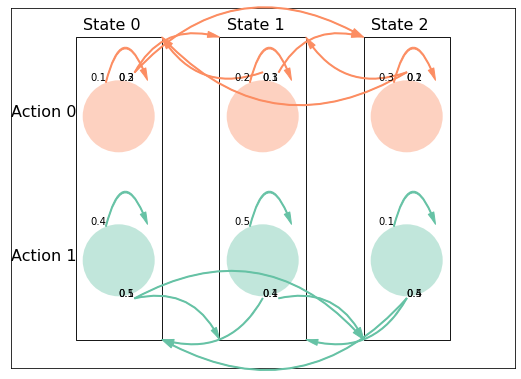

In [353]:
mdp.show()